**Pre Process the Data**

In [ ]:
import os
import pandas as pd
import numpy as np

# Function to process data for a single participant
def process_participant_data(participant_folder):
    # Read the raw data files
    hr = pd.read_csv(os.path.join(participant_folder, "HR.csv"), skiprows=2, header=None, names=["HR"])
    eda = pd.read_csv(os.path.join(participant_folder, "EDA.csv"), skiprows=2, header=None, names=["EDA"])
    ibi = pd.read_csv(os.path.join(participant_folder, "IBI.csv"), skiprows=1, header=None, names=["Time", "IBI"])

    # Get the initial timestamps
    with open(os.path.join(participant_folder, "HR.csv")) as f:
        hr_timestamp = int(float(f.readline().strip()))

    with open(os.path.join(participant_folder, "EDA.csv")) as f:
        eda_timestamp = int(float(f.readline().strip()))

    # Calculate respiration rate from IBI data
    ibi["respr"] = 1 / ibi["IBI"] * 60
    ibi = ibi.drop("IBI", axis=1)

    # Create time series data
    hr["Time(sec)"] = np.arange(hr_timestamp, hr_timestamp + len(hr), 1)
    eda["Time(sec)"] = np.arange(eda_timestamp, eda_timestamp + len(eda), 1)

    # Merge HR and EDA data
    merged_data = hr.merge(eda, on="Time(sec)")

    # Create a new DataFrame with unique time values
    unique_time_df = pd.DataFrame({"Time": np.arange(hr_timestamp, hr_timestamp + len(hr), 1)})

    # Convert the data type of the "Time" column in the "ibi" DataFrame to 'int64'
    ibi["Time"] = ibi["Time"].astype("int64")

    # Merge and interpolate IBI data to match HR and EDA data
    ibi_interp = pd.merge_asof(unique_time_df, ibi, on="Time", direction="nearest")

    # Merge IBI interpolated data
    merged_data = merged_data.merge(ibi_interp, left_on="Time(sec)", right_on="Time", how="left")
    merged_data = merged_data.drop("Time", axis=1)

    # Load tags_SX.csv for labeling
    tags = pd.read_csv(os.path.join(participant_folder, f"tags_{os.path.basename(participant_folder)}.csv"), header=None, names=["Timestamp"])
    merged_data["Label"] = 0

    # Add stress labels based on the tags file
    for i, row in tags.iterrows():
        merged_data.loc[(merged_data["Time(sec)"] >= row["Timestamp"]) & (merged_data["Time(sec)"] < tags.loc[i + 1, "Timestamp"] if i + 1 < len(tags) else merged_data["Time(sec)"].max()), "Label"] = 1 - i % 2

    # Add participant column
    participant_number = int(participant_folder[-2:])
    merged_data["Participant"] = participant_number

    return merged_data

# Process data for all participants
raw_data_folder = "/content/drive/MyDrive/Raw_data"
all_participants_data = []

for i in range(1, 36):
    participant_folder = os.path.join(raw_data_folder, f"S{i:02d}")
    print(f"Processing data for participant S{i:02d}...")
    participant_data = process_participant_data(participant_folder)
    all_participants_data.append(participant_data)

# Concatenate all participant data
all_participants_data = pd.concat(all_participants_data, ignore_index=True)

# Save the output file
output_file = "processed_data.csv"
all_participants_data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")


**Split Data**

In [3]:
from sklearn.model_selection import train_test_split

# Load the processed_data.csv file
data = pd.read_csv("processed_data.csv")

# Split the data into training and testing sets (80% for training, 20% for testing)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data["Participant"])


**Visualize Data**

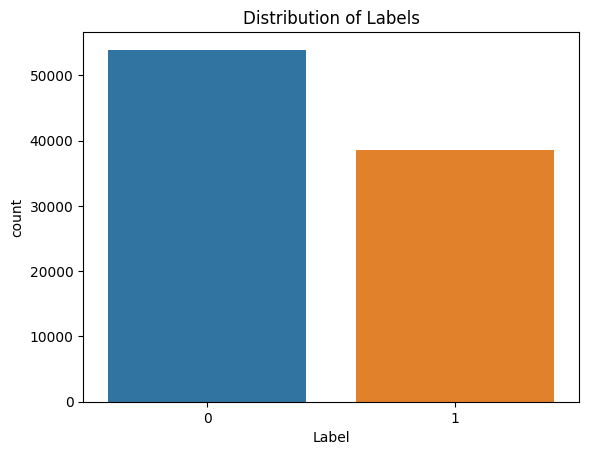

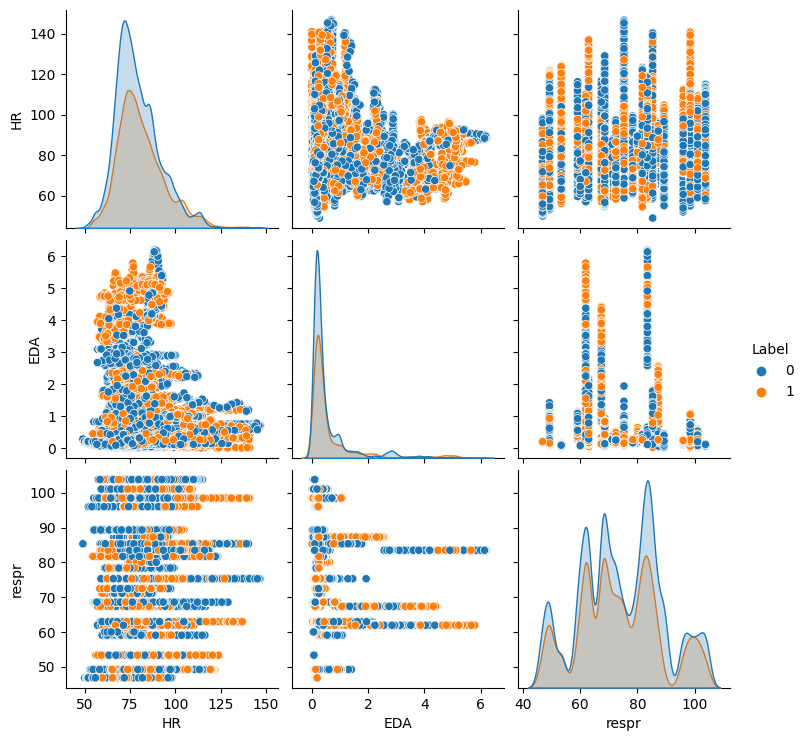

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of labels
sns.countplot(x="Label", data=train_data)
plt.title("Distribution of Labels")
plt.show()

# Visualize the relationship between different features and labels
sns.pairplot(train_data, hue="Label", vars=["HR", "EDA", "respr"])
plt.show()


**Develop and Test ML Models**

Logistic Regression:

              precision    recall  f1-score   support

           0       0.59      0.93      0.73     13571
           1       0.50      0.09      0.16      9573

    accuracy                           0.59     23144
   macro avg       0.55      0.51      0.44     23144
weighted avg       0.56      0.59      0.49     23144

Confusion Matrix:
[[12679   892]
 [ 8671   902]]


Random Forest:

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     13571
           1       0.88      0.87      0.88      9573

    accuracy                           0.90     23144
   macro avg       0.90      0.89      0.90     23144
weighted avg       0.90      0.90      0.90     23144

Confusion Matrix:
[[12465  1106]
 [ 1232  8341]]




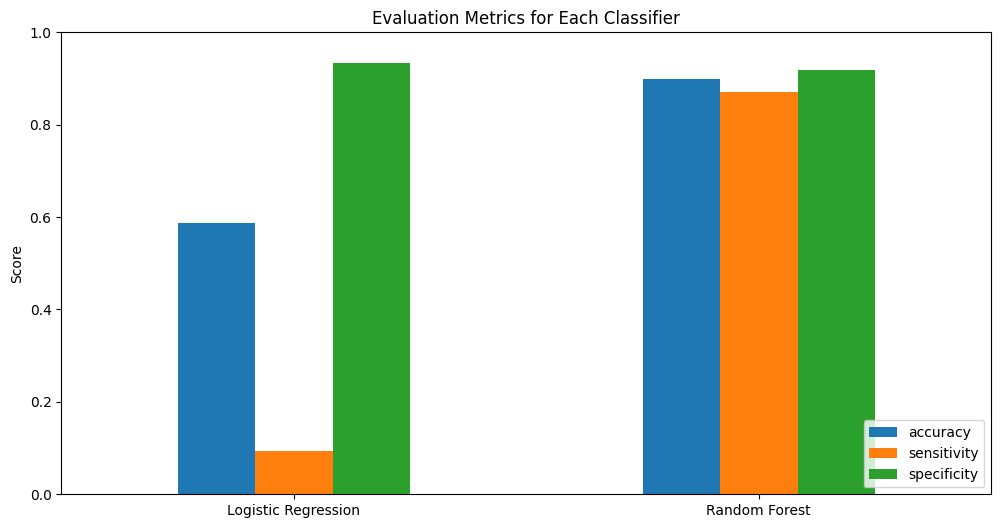

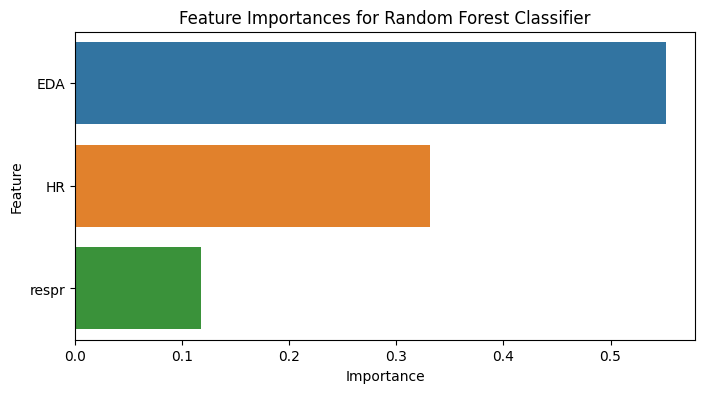

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Define feature columns and target column
feature_columns = ["HR", "EDA", "respr"]
target_column = "Label"

# Prepare the training and testing sets
X_train = train_data[feature_columns]
y_train = train_data[target_column]
X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Define different classifiers
classifiers = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    #"SVM": make_pipeline(StandardScaler(), SVC(random_state=42)),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate each classifier
for classifier_name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(f"{classifier_name}:\n")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


import numpy as np

# Calculate the evaluation metrics
evaluation_metrics = {}
for classifier_name, classifier in classifiers.items():
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    evaluation_metrics[classifier_name] = {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

# Plot the evaluation metrics for each classifier
metrics_df = pd.DataFrame(evaluation_metrics).transpose()
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Score')
plt.title('Evaluation Metrics for Each Classifier')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

# Feature importances for RandomForestClassifier (if applicable)
if 'Random Forest' in classifiers:
    importances = classifiers['Random Forest'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_columns, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    plt.figure(figsize=(8, 4))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances for Random Forest Classifier')
    plt.show()

